## Importation of libaries

In [1]:
# Pytorch

import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms
from torchvision.io import read_image
from torch.utils.data import Subset
import torch.nn.functional as F


# Huggingface python image models

import timm

# Insightface models

from backbones import get_model

# Images Libs

from PIL import Image
import PIL

# Numpy

import numpy as np

# Pandas

import pandas as pd

# Common Python Libs

import os
import math
import random


## Constants

In [2]:
TRAIN_BATCH_SIZE = 16
VALIDATION_BATCH_SIZE = 8

NUM_TRAINING_CLASS = 5013
NUM_VALIDATION_CLASS = 5013

## Util Functions

In [3]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x



## Get config

In [4]:
from utils.utils_config import get_config

cfg = get_config('configs/icartoonface_r50_onegpu')

## Initialize distributed

In [5]:
# from torch import distributed

# rank = 0
# local_rank = 0
# world_size = 1
# distributed.init_process_group(
#     backend="nccl",
#     init_method="tcp://127.0.0.1:12584",
#     rank=rank,
#     world_size=world_size,
# )

## CUDA



In [6]:
cuda_available = torch.cuda.is_available()
if cuda_available:
    print("CUDA is available!")
else:
    print("CUDA is not available. Switching to CPU mode.")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA is available!


# Model Development

## Create Model

In [7]:
model = get_model('r18')
model.load_state_dict(torch.load('/root/face-rnd/dat/insightface/pytorch/r18ms1mv3.pth', map_location='cuda:0'))

<All keys matched successfully>

## Freeze All layers

In [8]:
# for param in model.parameters():
#     param.requires_grad = False  # Freeze all parameters


## Modify Final Layers

In [9]:
num_ftrs_in = model.fc.in_features  
# print(num_ftrs_in)
model.fc = nn.Linear(num_ftrs_in, NUM_TRAINING_CLASS)  
model.fc.weight.requires_grad = True

model.features = nn.BatchNorm1d(NUM_TRAINING_CLASS, eps=1e-05)
nn.init.constant_(model.features.weight, 1.0)
model.features.weight.requires_grad = True

# model.features = Identity()

if cuda_available:
    model.to(device)

In [10]:
## Print The Model

In [11]:
print(model)

IResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prelu): PReLU(num_parameters=64)
  (layer1): Sequential(
    (0): IBasicBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=64)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): IBas

# Loss function and optimizer

## Loss Function

In [12]:
from losses import CombinedMarginLoss, ArcFace
from partial_fc_v2 import PartialFC_V2

### Focal Loss

In [13]:
class FocalLoss(nn.Module):

    def __init__(self, gamma=0, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.ce = torch.nn.CrossEntropyLoss()

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

### Angular Loss

In [14]:
class AngularLoss(torch.nn.Module):
    def __init__(self, class_num, radius=64.0, margin=5e-1):
        super(AngularLoss, self).__init__()
        self.radius = radius
        self.class_nums = class_num
        self.cos_margin = torch.cos(torch.tensor(margin))
        self.sin_margin = torch.sin(torch.tensor(margin))
        self.cross_entropy = self.cross_entropy_with_logsum

    def cross_entropy_with_logsum(self, logits, labels):
        logsum = torch.logsumexp(logits, dim=1, keepdim=True)
        log_probs = logits - logsum
        return F.nll_loss(log_probs, labels)
    
    

    def forward(self, logits, labels):
        target_mask = F.one_hot(labels, self.class_num)

        epsilon = 1e-8  # or a different small value
        sin_theta = torch.sqrt((1.0 - torch.pow(logits, 2)) + epsilon)
        arc_logits_target = logits * self.cos_margin - sin_theta * self.sin_margin
        arc_logits = self.radius * ((1 - target_mask) * logits + target_mask * arc_logits_target)

        loss = self.cross_entropy(arc_logits, labels)

        return loss

### Arcface Loss

In [15]:
class ArcFaceLoss(nn.Module):
    def __init__(self, num_classes, batch_size, s=30.0, m=0.5):
        super(ArcFaceLoss, self).__init__()
        self.num_classes = num_classes
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.randn(num_classes, batch_size) * 0.01)

    def forward(self, logits, labels):
        logits = F.normalize(logits, dim=1)
        weight = F.normalize(self.weight, dim=1)

        # Compute the cos(theta)
        cos_theta = logits @ weight

        # Compute the cos(theta + m)
        cos_theta_m = cos_theta - self.m

        # Get one-hot encoded labels
        one_hot = torch.zeros_like(cos_theta)
        one_hot.scatter_(1, labels.view(-1, 1), 1)

        # Compute the final logits with margin
        logits_arc = cos_theta * (1 - one_hot) + cos_theta_m * one_hot
        logits_arc *= self.s

        # Compute the cross-entropy loss
        loss = F.cross_entropy(logits_arc, labels)

        return loss


### Choosing the loss

In [16]:
criterion = ArcFaceLoss(NUM_TRAINING_CLASS, TRAIN_BATCH_SIZE, 30.0, 0.5).to('cuda:0')
# validation_criterion = ArcFaceLoss(NUM_VALIDATION_CLASS, VALIDATION_BATCH_SIZE, 16.0, 0.1).to('cuda:0')

# criterion = FocalLoss().to('cuda:0')
# criterion = AngularLoss()
# criterion = nn.CrossEntropyLoss().to(device)

## Optimizer

In [17]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# optimizer = torch.optim.SGD(
#     params=[{"params": model.parameters()}],
#     lr=cfg.lr, momentum=0.9, weight_decay=cfg.weight_decay)

## Transform function

In [18]:
transform = transforms.Compose([
    # transforms.Resize(112),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5677, 0.5188, 0.4885], std=[0.2040, 0.2908, 0.2848])
])

# Data Augmentation

## Data Augmentation using ImgAug

In [19]:
from imgaug import augmenters as iaa
import imgaug as ia

class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        # iaa.Scale((112, 112)),
        iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-20, 20), mode='symmetric'),
        iaa.Sometimes(0.25,
                      iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                 iaa.CoarseDropout(0.1, size_percent=0.5)])),
        iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
    ])
      
  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)

transforms_with_imgaug = ImgAugTransform()

## Data augmentation using pytorch

In [20]:
transforms_with_pytorch_aug = torchvision.transforms.Compose([
    # transforms.Resize(112),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5677, 0.5188, 0.4885], std=[0.2040, 0.2908, 0.2848]),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20)
])

# Dataset Building

## Train Dataset loading

In [21]:
train_dataset = datasets.ImageFolder(
    '/root/face-rnd/dat/personai_icartoonface_rectrain/icartoonface_rectrain', 
    transform=transform
)

train_loader = torch.utils.data.DataLoader(
    # Subset(train_dataset, list(range(1000))),
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True
)


# VALID_LABELS = list(range(400, 450))


# # Filter the training dataset to only include the valid labels
# train_dataset.targets = [target for target in train_dataset.targets if target in VALID_LABELS]
# train_dataset.samples = [(img, target) for img, target in train_dataset.samples if target in VALID_LABELS]



### Prevent Oversampling



In [22]:
# from torchsampler import ImbalancedDatasetSampler

# train_dataset = datasets.ImageFolder(
#     '/root/face-rnd/dat/personai_icartoonface_rectrain/icartoonface_rectrain', 
#     transform=transform
# )

# train_loader = torch.utils.data.DataLoader(
#     train_dataset,
#     sampler=ImbalancedDatasetSampler(train_dataset),
#     batch_size=TRAIN_BATCH_SIZE,
#     # shuffle=True
# )

# # VALID_LABELS = list(range(400, 450))

# # # Filter the training dataset to only include the valid labels
# # train_dataset.targets = [target for target in train_dataset.targets if target in VALID_LABELS]
# # train_dataset.samples = [(img, target) for img, target in train_dataset.samples if target in VALID_LABELS]



# Validation Dataset Loading 

## Validation Set

In [23]:
class ImageDataset(Dataset):
    def __init__(self, data_file, root_dir, transform=None, valid_labels=None):
        self.data = []

        with open(data_file, 'r') as f:
            for line in f:
                line = line.strip()
                try:
                    if line:
                        filename, x1, y1, x2, y2, label = line.split('\t')
                        if valid_labels and int(label) not in valid_labels:
                            continue
                        self.data.append((os.path.join(root_dir, filename), int(x1), int(y1), int(x2), int(y2), int(label)))
                except ValueError:
                    pass
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        filename, x1, y1, x2, y2, label = self.data[index]
        image = read_image(filename)
        # image = image[:, y1:y2, x1:x2]  # Crop the image using the bounding box coordinates

        if self.transform:
            image = self.transform(image)

        return image, label

transform_ = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(112),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5677, 0.5188, 0.4885], std=[0.2040, 0.2908, 0.2848])
])

dataset = ImageDataset(
    '/root/face-rnd/dat/icartoonface_rectest_info.txt', 
    '/root/face-rnd/dat/personai_icartoonface_rectest/icartoonface_rectest',
    transform=transform_,
    valid_labels=list(range(40, 50))
)

validation_loader = DataLoader(dataset, batch_size=VALIDATION_BATCH_SIZE, shuffle=True)


## View The Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


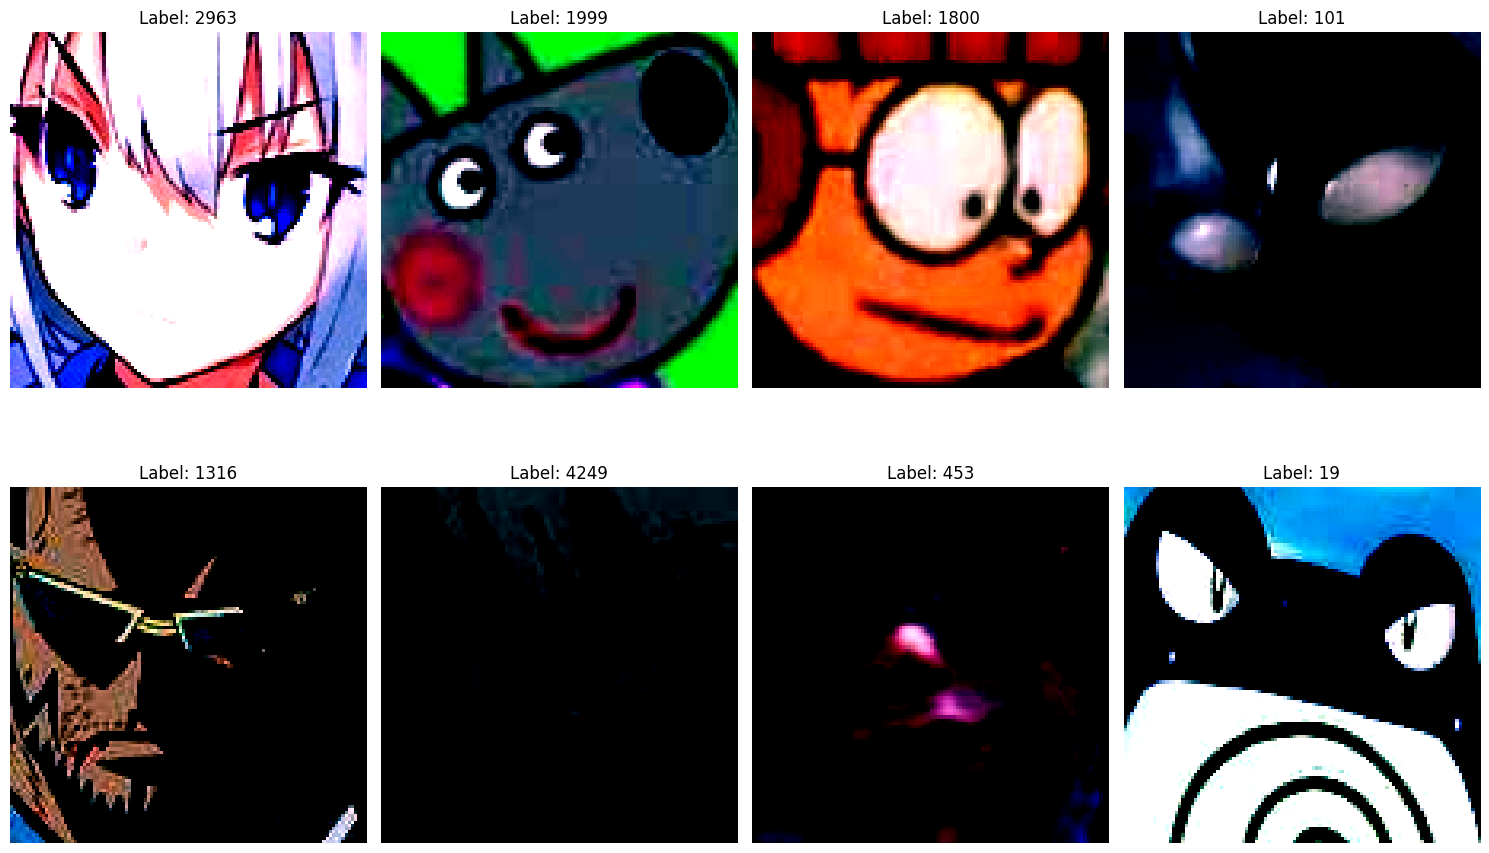

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


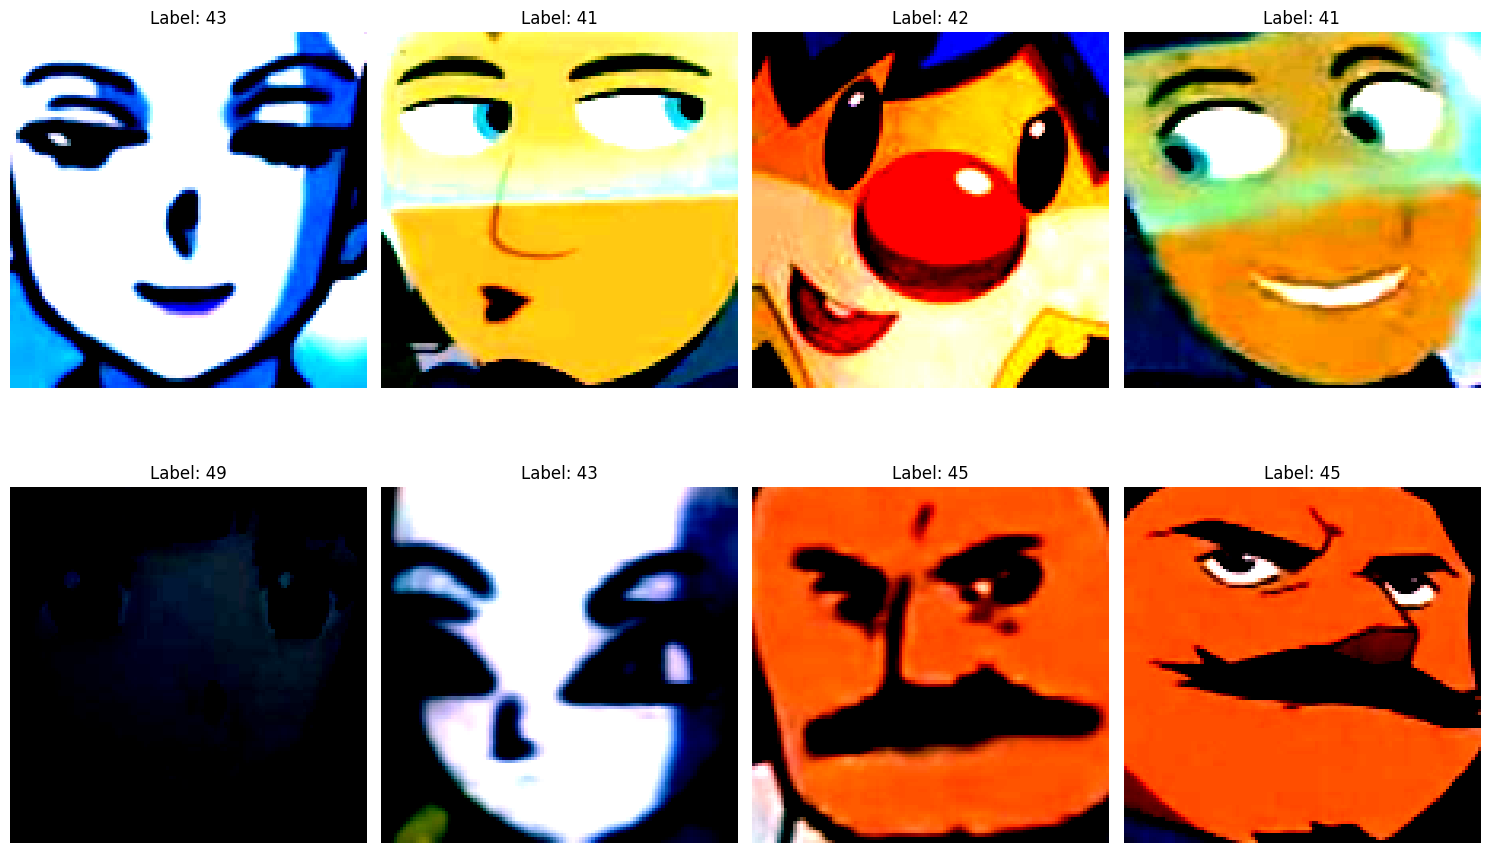

In [24]:
import matplotlib.pyplot as plt
import torch
import random


def print_images(dataloader, num_images=4, target_label=None, random_order=True):
    """
    Prints a grid of images from the dataloader.

    Args:
        dataloader (torch.utils.data.DataLoader): The dataloader containing images and labels.
        num_images (int, optional): The number of images to print. Defaults to 4.
        target_label (int, optional): The class label to filter images by.
            If None, all images are printed. Defaults to None.
        random_order (bool, optional): If True, prints random images.
            If False, prints images sequentially. Defaults to True.
    """

    # Get a batch of images and labels
    try:
        inputs, labels = next(iter(dataloader))
    except StopIteration:
        print("Warning: DataLoader is exhausted. No images to print.")
        return

    # Filter images by label if specified
    if target_label is not None:
        filtered_indices = (labels == target_label).nonzero(as_tuple=True)[0]
        if len(filtered_indices) == 0:
            print(f"Warning: No images found for label {target_label}.")
            return
        inputs = inputs[filtered_indices]
        labels = labels[filtered_indices]

    # Select image indices based on random_order
    if random_order:
        indices = random.sample(range(len(inputs)), num_images)  # Random selection
    else:
        indices = list(range(min(num_images, len(inputs))))  # Sequential selection

    # Calculate number of rows based on num_images
    num_rows = (num_images // 4) + (num_images % 4 > 0)  # Integer division with remainder check

    # Create a figure and subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=min(4, num_images), figsize=(15, 5 * num_rows))

    # Loop through the subplots and print images
    for i, idx in enumerate(indices):
        if i >= num_images:
            break

        # Print the image
        ax = axes.flat[i]
        ax.imshow(inputs[idx].permute(1, 2, 0))  # Assuming (C, H, W) format
        ax.set_title(f"Label: {labels[idx].item()}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


# Example usage
# Assuming you have a dataloader named 'train_loader'
# print_images(train_loader)  # Print 4 random images (default)


print_images(train_loader, num_images=8, random_order=True)

print_images(validation_loader, num_images=8, random_order=True)

# Print 3 random images of any class
# print_images(train_loader, num_images=3)


    
## Training The model

In [25]:
for epoch in range(100):  
    model.train()
    running_loss = 0.0
    train_acc = 0.0
    for inputs, labels in train_loader:
        # print(labels)
        inputs, labels = inputs.to(device), labels.to(device)
        # optimizer.zero_grad()
        outputs = model(inputs)
        # print(labels.shape)
        loss = criterion(outputs, labels)
        # print(loss)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        train_acc += torch.sum(preds == labels.data)
        running_loss += loss.item()
        # print(running_loss/len(inputs))

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Accuracy: {train_acc/len(train_loader.dataset)}")

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            # print(labels)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_acc += torch.sum(preds == labels.data)

    val_loss /= len(validation_loader)
    val_acc /= len(validation_loader.dataset)
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")


../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [0,0,0], thread: [0,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [0,0,0], thread: [1,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [0,0,0], thread: [2,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [0,0,0], thread: [3,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [0,0,0], thread: [4,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [0,0,0], 

RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## Test some images

In [ ]:
model.eval()

def get_predicted_class(img_path):
    img_path = f'/root/face-rnd/dat/personai_icartoonface_rectrain/icartoonface_rectrain/{img_path}'
    x = model(transform(Image.open(img_path).convert('RGB')).to("cuda:0").unsqueeze(0))
    probabilities = nn.functional.softmax(x, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class.item()

In [ ]:
get_predicted_class('personai_icartoonface_rectrain_00000/personai_icartoonface_rectrain_00000_0000001.jpg')